In [13]:
import pandas as pd
import optuna
import numpy as np
from pycaret.datasets import get_data
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn. preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import xgboost as xgb

In [14]:
df = get_data('house')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


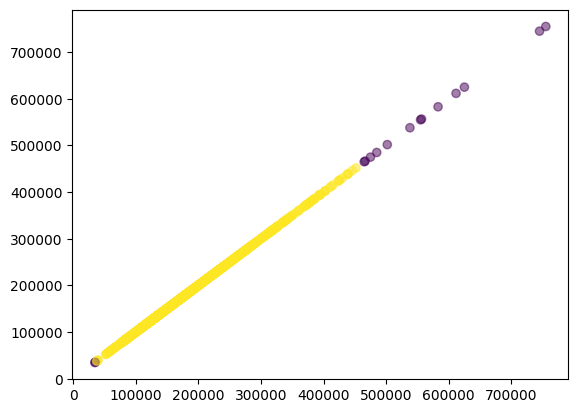

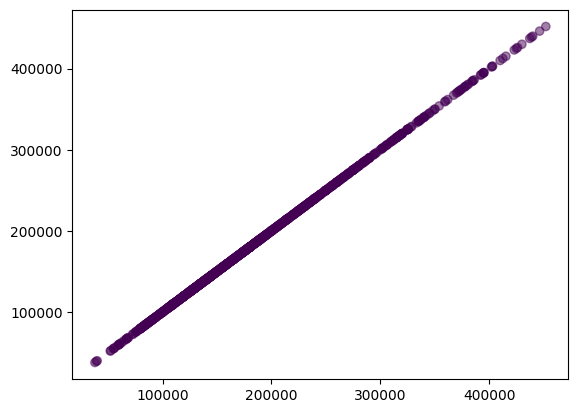

In [3]:
anom = IsolationForest(contamination=0.01, random_state=42)
anom.fit(df['SalePrice'].to_frame())

prediction_anomaly = anom.predict(df['SalePrice'].to_frame())

df['Anomaly'] = prediction_anomaly

plt.scatter(df['SalePrice'],df['SalePrice'],c=prediction_anomaly,cmap='viridis',alpha=0.5)
plt.show()

df = df.loc[df['Anomaly'] == 1]

plt.scatter(df['SalePrice'],df['SalePrice'],c=df['Anomaly'],cmap='viridis',alpha=0.5)
plt.show()

#df = df.drop('Anomaly', axis=1)

In [15]:
remover = df.columns[(df.isna().sum()/df.shape[0])>0.1]
df = df.drop(remover, axis=1)
df = df.fillna(method='ffill')
remover_obj = df.select_dtypes(include='object')
obj_columns = remover_obj.columns[remover_obj.nunique()>7]
df = df.drop(obj_columns, axis=1)

In [16]:
numerador = MinMaxScaler()
binarizador = OneHotEncoder(sparse=False)

In [17]:
X_num = numerador.fit_transform(df.drop('SalePrice', axis=1).select_dtypes(exclude='object'))
X_bin = binarizador.fit_transform(df.select_dtypes(include='object'))
X = np.append(X_num, X_bin, axis=1)

pca = PCA(n_components=60, random_state=42)
X = pca.fit_transform(X)

y = df['SalePrice']
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

def testar(folds):
    n_estimators = folds.suggest_int('n_estimators', 50,600)
    max_depth = folds.suggest_int('max_depth', 1,15)
    #max_features = folds.suggest_int('max_features', 1,12)
    #max_samples = folds.suggest_int('max_samples', 1,12)

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=n_estimators, max_depth=max_depth)
    score = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=9).mean()

    return score

#objective='reg:squarederror'
#objective='multi:softmax'
#objective='binary:logistic'

study = optuna.create_study(direction='maximize')
study.optimize(testar, n_trials=20)

best_params = study.best_params
best_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

best_model.fit(X_train, y_train)
print(best_model.score(X_train, y_train))


[I 2024-02-02 12:59:38,574] A new study created in memory with name: no-name-cf1fcb98-f0e0-4a21-aeaa-4118ddcd788f


(1460, 60)


[I 2024-02-02 12:59:42,838] Trial 0 finished with value: 0.6600113776113142 and parameters: {'n_estimators': 249, 'max_depth': 7}. Best is trial 0 with value: 0.6600113776113142.
[I 2024-02-02 12:59:46,214] Trial 1 finished with value: 0.6081120380158096 and parameters: {'n_estimators': 80, 'max_depth': 10}. Best is trial 0 with value: 0.6600113776113142.
[I 2024-02-02 12:59:48,687] Trial 2 finished with value: 0.7023490034984101 and parameters: {'n_estimators': 377, 'max_depth': 5}. Best is trial 2 with value: 0.7023490034984101.
[I 2024-02-02 12:59:50,927] Trial 3 finished with value: 0.6121069587965104 and parameters: {'n_estimators': 65, 'max_depth': 9}. Best is trial 2 with value: 0.7023490034984101.
[I 2024-02-02 12:59:58,739] Trial 4 finished with value: 0.6121068554427946 and parameters: {'n_estimators': 305, 'max_depth': 9}. Best is trial 2 with value: 0.7023490034984101.
[I 2024-02-02 12:59:58,819] Trial 5 finished with value: 0.7253375197340394 and parameters: {'n_estimators

0.85391930103429


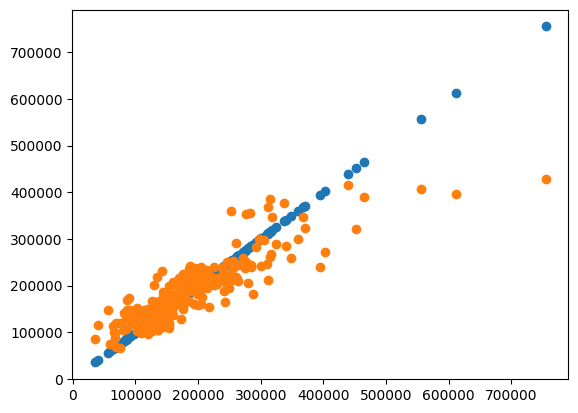

In [18]:
plt.scatter(y_test, y_test)
plt.scatter(y_test, best_model.predict(X_test))
plt.show()

In [19]:
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=169, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


In [20]:
df_anomaly = pd.DataFrame(best_model.predict(X_test), columns=['Predict'])
df_anomaly

,Predict
0,158065.468750
1,288721.562500
2,125721.375000
3,157093.546875
4,386086.531250
...,...
287,173673.093750
288,290615.718750
289,219208.531250
290,121520.757812


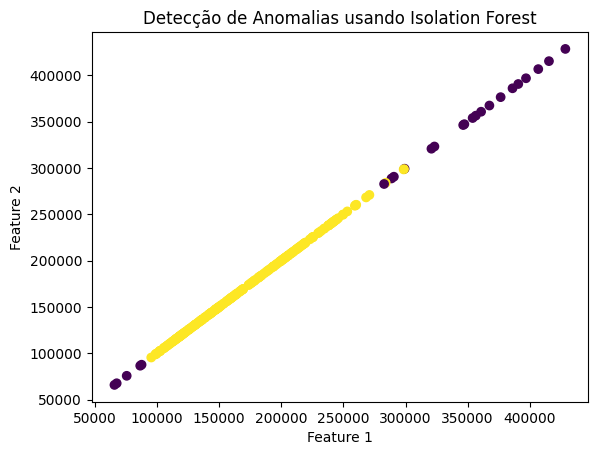

In [21]:


model_anomaly = IsolationForest(contamination=0.08, random_state=42)
model_anomaly.fit(df_anomaly)

predictions = model_anomaly.predict(df_anomaly)

plt.scatter(df_anomaly,df_anomaly, c=predictions, cmap='viridis')
plt.title('Detecção de Anomalias usando Isolation Forest')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [22]:
df_anomaly_2 = df_anomaly
df_anomaly_2['Predictions'] = predictions
df_anomaly_2


,Predict,Predictions
0,158065.468750,1
1,288721.562500,-1
2,125721.375000,1
3,157093.546875,1
4,386086.531250,-1
...,...,...
287,173673.093750,1
288,290615.718750,-1
289,219208.531250,1
290,121520.757812,1
